# Machine Translation with Seq2seq models via Pytorch

The goal of this lab are to:
- Familiarize yourself with the task of **Machine Translation (MT)**
- Implement a basic **recurrent sequence-to-sequence** model in Pytorch
- Train the model on a very simple English-French MT dataset
- Implement an **attention** module into the model and visualize its results

We will **for most of this lab** focus on the model and leave aside what are normally very important aspects of Machine Learning methodology: in particular, we won't use validation and test data to search for hyperparameter search. We will **split the data and retrain the model at the end of the lab** for a comparative performance evaluation.

In [83]:
# General stuff
from io import open
import re
import random
import numpy as np
import matplotlib.pyplot as plt

# Nice printing
from pprint import pprint

# Pytorch
import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# Which device to use ?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### I Dataset and pre-processing

We're going to work with data from the **tatoeba** website. This website proposes human-made translations for many (relatively) simple sentences, with sometimes several possible translations for one sentence.
Pre-processed versions of the *tatoeba dataset* can be found on this [website](https://www.manythings.org/anki/). You are given the 'English $\rightarrow$ French' data already cleaned, but you are free to use any other language you would prefer.  


<div class='alert alert-block alert-warning'>
            Question:</div>
            
We will define these as global variables - for convenience. Given what was said in class and how they are employed in this lab, explain briefly what each one is used for.

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
# Some global variables
PAD_TOKEN = 0 # padding, enabling batch processing of sentences with different lengths.
SOS_TOKEN = 1 # Start Of Sequence, used to indicate when the decoder should start generating translations.
EOS_TOKEN = 2 # End Of Sequence, used to indicate when the decoder should stop generating translations.

From the previous pytorch lab, we know we will require to define some parameters. We can already choose the maximum length of sequences, the size of our batches, and the internal dimension used by our model. Note that the length of sequence is rather short in this data - you can take a look at the histogram.

**Put ```fra.txt``` in the current directory**.

In [86]:
# Parameters
max_length = 10
batch_size = 32
hidden_size = 128

In [87]:
# Read the file and split into lines
parallel = open('/content/drive/MyDrive/NLP/Dataset/fra.txt', encoding='utf-8').\
        read().strip().split('\n')

In [88]:
# Data looks like this
pprint(parallel[0:5])

['Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & '
 '#1158250 (Wittydev)',
 'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & '
 '#8090732 (Micsmithel)',
 'Go.\tEn route !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & '
 '#8267435 (felix63)',
 'Go.\tBouge !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & '
 '#9022935 (Micsmithel)',
 'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & '
 '#509819 (Aiji)']


We will need to clean this up. Use the regular expression package ```re``` to remove any non letter character. Be careful, though, with French, you need to keep the accents. We will then organize the data into pairs, as is usual in MT.

<div class='alert alert-block alert-info'>
            Code:</div>

In [89]:
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
  s = s.lower().strip()
  #Remove unwanted characters except letters,accents and spaces
  s = re.sub(r"[^a-zA-ZÀ-ÿ\s]","",s)
  return s

In [90]:
# Split every line into pairs and normalize
pairs = [[normalizeString(s) for s in l.split('\t')] for l in parallel]

In [91]:
pprint(pairs[0:5])

[['go', 'va ', 'ccby  france attribution tatoebaorg  cm   wittydev'],
 ['go', 'marche', 'ccby  france attribution tatoebaorg  cm   micsmithel'],
 ['go', 'en route ', 'ccby  france attribution tatoebaorg  cm   felix'],
 ['go', 'bouge ', 'ccby  france attribution tatoebaorg  cm   micsmithel'],
 ['hi', 'salut ', 'ccby  france attribution tatoebaorg  cm   aiji']]


Begin with implementing a class ```Vocab``` that will accumulate counts and indexes of words into language-specific dictionnaries. In this case, we would like the vocabulary to be built on the fly, to work well with the format of our data (parallel sentences from both languages).

<div class='alert alert-block alert-info'>
            Code:</div>

In [92]:
class Vocab:
    def __init__(self):
        self.word2count = {}
        self.word2idx = {"SOS": SOS_TOKEN, "EOS": EOS_TOKEN}
        self.idx2word = {SOS_TOKEN: "SOS", EOS_TOKEN: "EOS"}
        self.n_words = 2

    # Implemented assuming we will process lines one by one, easier given the format of our data
    def addSent(self, sent):
        # Split the sentence by spaces, then add each word to the dictionary
        for word in sent.split():
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2count:
            self.word2count[word] = 1
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def __len__(self):
        # The number of ordinary words excluding special tokens
        return len(self.word2idx)

Then, create a function ```tensorFromSentence``` that will take an untokenized sentence (hence, a string), a ```Vocab``` object, and the ```max_length``` parameter as inputs, and return a ```LongTensor``` representing the sequence of indexes.

<div class='alert alert-block alert-info'>
            Code:</div>

In [93]:
def tensorFromSentence(sent, vocab, max_length=10):
    # 1) First, split the sentence into tokens and convert each token into an index (skip or handle OOV if not in the dictionary)
    indices = []
    for word in sent.split():
        if word in vocab.word2idx:
            indices.append(vocab.word2idx[word])
        # else: handle OOV
    # 2) Add EOS at the end
    indices.append(EOS_TOKEN)

    # 3) If it exceeds max_length, truncate
    if len(indices) > max_length:
        indices = indices[:max_length]
    # 4) If it's shorter than max_length, pad to max_length
    else:
        indices += [PAD_TOKEN]*(max_length - len(indices))

    # 5) Convert to a tensor
    return torch.tensor(indices, dtype=torch.long)

Finally, complete this ```TranslationDataset``` class inheriting from ```Dataset```. It should, from the list of parallel sentences:
- Apply an optional filter to possibly reduce the dataset size and complexity,
- Instantiate and build ```Vocab``` objects for both languages,
- Create two lists containing ```LongTensor``` objects for each language,
- Group them into two tensors of the appropriate size with ```pad_sequence```.

You should note that, depending on the ordering of the pairs, one language will be the **source**, and the other will be the **target** of our model. In this case, English is the source and French the target.
<div class='alert alert-block alert-info'>
            Code:</div>

In [94]:
class TranslationDataset(Dataset):
    def __init__(self, parallel_data, max_length = 10, filter_target_prefixes = None):
        # 1) Optional filtering
        self.pairs = self.filterData(parallel_data, filter_target_prefixes)

        # 2) Create vocabulary (English/French)
        self.max_length = max_length
        self.input_lang = Vocab()   # English
        self.output_lang = Vocab()  # French

        # 3) Store tensors of all sentences
        self.tensor_inputs = []
        self.tensor_outputs = []

        # 4) Iterate through pairs, add words to the vocabulary, and convert sentences to tensors
        for pair in self.pairs:
            src_sent = pair[0]
            tgt_sent = pair[1]
            self.input_lang.addSent(src_sent)
            self.output_lang.addSent(tgt_sent)

        # Iterate again, after building the vocabulary, convert sentences into tensors
        for pair in self.pairs:
            src_sent = pair[0]
            tgt_sent = pair[1]
            self.tensor_inputs.append(
                tensorFromSentence(src_sent, self.input_lang, max_length)
            )
            self.tensor_outputs.append(
                tensorFromSentence(tgt_sent, self.output_lang, max_length)
            )

        # 5) Combine lists into uniformly sized tensors
        # If tensorFromSentence has already fixed the length to max_length, pad_sequence may not be needed here
        self.tensor_inputs = pad_sequence(self.tensor_inputs, batch_first=True,
                                          padding_value=PAD_TOKEN)
        self.tensor_outputs = pad_sequence(self.tensor_outputs, batch_first=True,
                                           padding_value=PAD_TOKEN)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        # The iterator retrieves a single example
        # The dataloader will handle shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_inputs[idx], self.tensor_outputs[idx]

    def filterPair(self, pair, prefixes):
        return pair[0].startswith(prefixes)

    def filterData(self, pairs, filter_target_prefixes):
        if filter_target_prefixes is not None:
            return [pair for pair in pairs if self.filterPair(pair, filter_target_prefixes)]
        else:
            return pairs


Create a ```TranslationDataset``` from our data, with no filter, and look at its size, and the sizes of the vocabularies. What could be a problem here ?

<div class='alert alert-block alert-warning'>
            Question:</div>
            The potential problem here is that the vocabulary size is too large, especially for the target language (French) with over 32,000 unique words, which can negatively impact model efficiency and generalization. This could be caused by rare words, typos, or noisy data that were not filtered out. Additionally, without a minimum frequency threshold, infrequent words may inflate the vocabulary unnecessarily. Another issue might be sentence length inconsistencies, where very long sentences get truncated, leading to information loss, while short sentences are padded excessively. To address this, applying a frequency-based vocabulary cutoff, limiting the maximum vocabulary size, and ensuring proper data cleaning could significantly improve performance.

In [95]:
input_file = "/content/drive/MyDrive/NLP/Dataset/fra.txt"
output_file = "/content/drive/MyDrive/NLP/Dataset/fra_clean.txt"

with open(input_file, "r", encoding="utf-8") as fin, \
     open(output_file, "w", encoding="utf-8") as fout:
    for line in fin:
        # Find the position of "CC-BY"
        idx = line.find("CC-BY")
        if idx != -1:
            # Remove everything after "CC-BY"
            line = line[:idx]
        # Trim leading and trailing spaces
        line = line.strip()
        # If the line still contains content, write it to the file
        if line:
            fout.write(line + "\n")


In [96]:
pairs = []
clean_file_path = "/content/drive/MyDrive/NLP/Dataset/fra_clean.txt"

with open(clean_file_path, "r", encoding="utf-8") as f:
    for line in f:
        # Remove leading and trailing spaces
        line = line.strip()
        # Split using tab character
        splitted = line.split('\t')
        # Ensure the line contains exactly two columns, otherwise skip it
        if len(splitted) < 2:
            continue

        eng = splitted[0].lower().strip()
        fra = splitted[1].lower().strip()
        pairs.append((eng, fra))

print(f"Total number of sentence pairs read: {len(pairs)}. Examples:")
for i in range(3):
    print(pairs[i])

# Assuming the TranslationDataset class has been implemented
# and it can accept filter_target_prefixes=None to disable filtering
max_length = 10  # For example, truncate/pad to 10 words
dataset = TranslationDataset(pairs, max_length=max_length, filter_target_prefixes=None)

print(f"\n[No Filtering] Dataset size: {len(dataset)}")
print(f"Source vocab size (Eng): {dataset.input_lang.n_words}")
print(f"Target vocab size (Fra): {dataset.output_lang.n_words}")


Total number of sentence pairs read: 232736. Examples:
('go.', 'va !')
('go.', 'marche.')
('go.', 'en route !')

[No Filtering] Dataset size: 232736
Source vocab size (Eng): 30408
Target vocab size (Fra): 48617


We will now use a filter: we will only consider pairs of sentences which English begins with chains of characters from the ```prefixes``` set.

- Create the dataset with this filter.
- Look at the sizes involved.
- **Split the data and keep a small subset for testing** (done at the end of the lab)
- Create a dataloader with the previously defined ```batch_size```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [97]:
# Consider only the sentences beginning with these prefixes
prefixes = ("i am ", "i m ",
            "he is", "he s ",
            "she is", "she s ",
            "you are", "you re ",
            "we are", "we re ",
            "they are", "they re ")

# Reconstruct the dataset with filtering
training_dataset = TranslationDataset(pairs, max_length=max_length, filter_target_prefixes=prefixes)

print(f"[After Filtering] Dataset size: {len(training_dataset)}")
print(f"Filtered source vocab (Eng): {training_dataset.input_lang.n_words}")
print(f"Filtered target vocab (Fra): {training_dataset.output_lang.n_words}")


[After Filtering] Dataset size: 3536
Filtered source vocab (Eng): 2582
Filtered target vocab (Fra): 3516


In [98]:
from torch.utils.data import random_split

train_size = int(0.9 * len(training_dataset))
test_size = len(training_dataset) - train_size

train_dataset, test_dataset = random_split(training_dataset, [train_size, test_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 3182
Test dataset size: 354


In [99]:
# Creating the dataloader
from torch.utils.data import DataLoader

batch_size = 32
training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dataloaders created successfully!")


Dataloaders created successfully!


### II - Sequence to sequence architecture and training

We will now create two pytorch objects, which will inherit from ```Module```: the ```EncoderRNN``` and the ```DecoderRNN``` classes. Both are based on RNNs; we will use the lighter ```GRU``` (gated recurrent unit) recurrent layer.
While we won't check it with validation data, we should try to avoid overfitting with ```Dropout```.

Begin by completing the **encoder**. It uses an ```Embedding``` layer, which has as many vectors as the size of the **source** vocabularies, plus the ```GRU```. Both embeddings and the recurrent layer use dimension ```hidden_size```. It should output two things:
- A sequence of vectors, corresponding to the representations of each input word that has gone through the encoder,
- The last hidden state used by the GRU of the encoder.

**Important**: with our first decoder, we will only use the **last hidden state**. However, we can still add the sequence of representations to the outputs, as we will need it for the *attention module* later.

<div class='alert alert-block alert-info'>
            Code:</div>

In [100]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        """
        input_size: Vocabulary size of the source language (i.e., embedding vocabulary size)
        hidden_size: Dimension of the hidden state vector in the GRU
        dropout_p: Dropout probability applied after embedding
        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # 1) Embedding layer, input dimension = input_size, output dimension = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)

        # 2) GRU layer, input dimension = hidden_size, output dimension = hidden_size
        # batch_first=True means the first dimension of input/output is batch_size
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

        # 3) Dropout layer, randomly zero out elements in the embedding output
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input_tensor):
        """
        input_tensor: shape [batch_size, seq_len]
        Returns:
          output:  GRU outputs for all time steps (batch_size, seq_len, hidden_size)
          hidden:  Hidden state of the last time step (1, batch_size, hidden_size)
        """
        # 1) Embedding layer + dropout
        embedded = self.dropout(self.embedding(input_tensor))
        # embedded shape: [batch_size, seq_len, hidden_size]

        # 2) Pass through GRU
        output, hidden = self.gru(embedded)
        # output shape: (batch_size, seq_len, hidden_size)
        # hidden shape: (1, batch_size, hidden_size)

        return output, hidden

Next, you will need to complete the **decoder**. Besides the ```Embedding``` (for the **target** language) and ```GRU```, it needs an additional layer: a ```Linear``` layer to obtain output scores for the next word to be predicted.
The ```forward``` function is however a little more complicated: we will need it to be able to re-use what was predicted at the previous step during inference. Therefore, we will use the old-fashioned way: a **loop**. To summarize, we will:
- Create an empty tensor containing only the first token of the output sequence (*which is ?*) with ```torch.empty```.
- If we are in training mode, we can fill out that tensor with what we know to be the rest of the output sequence, make it go through the recurrent layer, and obtain scores.
- If we are in inference mode, we need to make a prediction at each step to re-insert the corresponding index as input afterwards. We can use the ```topk``` method to get the best index directly ! **Important:** use the ```detach()``` method to cut this from the computational graph.  

In both cases, we loop through the sequence and apply the same operations, which are in ```forward_step```. We return the log-probabilities of prediction at each step.

**Important:** Again, we also return an empty placeholder variable which we will later use for attention.

<div class='alert alert-block alert-info'>
            Code:</div>

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        """
        hidden_size: Matches the hidden_size of the encoder
        output_size: Vocabulary size of the target language
        dropout_p:   Dropout applied to the input embedding
        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Converts "target language word index" -> "word vector"
        self.embedding = nn.Embedding(output_size, hidden_size)

        # GRU input = hidden_size, output = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

        # Maps GRU output to vocabulary size to obtain word distribution
        self.out = nn.Linear(hidden_size, output_size)

        # Dropout
        self.dropout = nn.Dropout(dropout_p)

    def forward_step(self, input_step, hidden):
        """
        Single-step prediction:
        input_step: [batch_size, 1], represents the word index at the current time step
        hidden:     [1, batch_size, hidden_size], represents the hidden state of the previous time step
        Returns:
          output: [batch_size, 1, output_size]
          hidden: [1, batch_size, hidden_size]
        """
        # 1) Embedding + dropout
        embedded = self.dropout(self.embedding(input_step))
        # embedded: [batch_size, 1, hidden_size]

        # 2) Pass through GRU
        output, hidden = self.gru(embedded, hidden)
        # output: [batch_size, 1, hidden_size]

        # 3) Fully connected layer mapping to output_size (vocabulary size), followed by log_softmax
        output = self.out(output)               # [batch_size, 1, output_size]
        output = F.log_softmax(output, dim=-1)  # Log probabilities

        return output, hidden

    def forward(self, encoder_outputs, encoder_hidden, max_length, target_tensor=None):
        """
        encoder_outputs: [batch_size, seq_len, hidden_size] (Not used in this model, reserved for Attention)
        encoder_hidden:  [1, batch_size, hidden_size], the last hidden state of the encoder
        max_length:      Length of the sequence to decode
        target_tensor:   [batch_size, seq_len], if not None, training mode with teacher forcing

        Returns:
          decoder_outputs: [batch_size, max_length, output_size], output for all time steps
          decoder_hidden:  [1, batch_size, hidden_size], last hidden state
          None            # Placeholder for possible attention weights in the future
        """
        batch_size = encoder_hidden.size(1)  # If encoder_hidden: (1, batch_size, hidden_size)
                                            # Alternatively: batch_size = encoder_outputs.size(0)
        # Initialize decoder input: fill with SOS_TOKEN=1 (can also be passed externally)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=encoder_hidden.device).fill_(1)

        # Initial hidden state
        decoder_hidden = encoder_hidden

        # Collect outputs for each step
        decoder_outputs = []

        # Step-by-step decoding
        for t in range(max_length):
            # 1) Call single-step prediction
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            # decoder_output: [batch_size, 1, output_size]

            # 2) Save result
            decoder_outputs.append(decoder_output)

            # 3) Distinguish between training mode (teacher forcing) and inference mode (self-generated predictions)
            if target_tensor is not None:
                # Teacher forcing: use the target word as the next input
                # target_tensor[:, t] shape: [batch_size]
                next_input = target_tensor[:, t].unsqueeze(1)  # [batch_size, 1]
                decoder_input = next_input
            else:
                # Inference mode: use top-1 predicted result as the next input
                topv, topi = decoder_output.topk(1, dim=-1)
                # topi shape: [batch_size, 1, 1]
                # Extract predicted word index
                decoder_input = topi.squeeze(2).detach()
                # decoder_input shape: [batch_size, 1]

        # Concatenate all time steps along the seq_len dimension (dim=1)
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        # decoder_outputs: [batch_size, max_length, output_size]

        # log_softmax has already been applied in forward_step; additional softmax can be applied here if needed
        # decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

        # Returning None as a placeholder for future attention mechanism
        return decoder_outputs, decoder_hidden, None


Create an instance of one ```EncoderRNN``` and one ```DecoderRNN```. In order to do this, get the vocabulary sizes for the appropriate languages from the ```TranslationDataset``` object.

<div class='alert alert-block alert-info'>
            Code:</div>

In [102]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EncoderRNN, DecoderRNN classes are assumed to be implemented above
# from ... import EncoderRNN, DecoderRNN

# Note: In training_dataset:
# - training_dataset.input_lang.n_words is the vocabulary size of the source language (English)
# - training_dataset.output_lang.n_words is the vocabulary size of the target language (French)
input_size = training_dataset.input_lang.n_words
output_size = training_dataset.output_lang.n_words

# You can manually set the hidden_size here
hidden_size = 256

# Instantiate models and move them to the selected device
encoder = EncoderRNN(input_size, hidden_size, dropout_p=0.1).to(device)
decoder = DecoderRNN(hidden_size, output_size, dropout_p=0.1).to(device)

print("Encoder and Decoder created successfully!")
print("Using device:", device)
print(f"Input vocab size (src lang): {input_size}")
print(f"Output vocab size (tgt lang): {output_size}")
print(f"Hidden size: {hidden_size}")


Encoder and Decoder created successfully!
Using device: cuda
Input vocab size (src lang): 2582
Output vocab size (tgt lang): 3516
Hidden size: 256


Implement the training loop into the ```train_epoch``` function. Follow the model from the previous lab. Note that we will use separated *optimizers* for the encoder and decoder. **Be careful to the sizes of the model outputs for use with the criterion !**

<div class='alert alert-block alert-info'>
            Code:</div>

In [103]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0

    for data in dataloader:
        # 1) Retrieve data from dataloader and move it to GPU/CPU
        input_tensor, target_tensor = data
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # 2) Initialize gradients
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # 3) Forward pass
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor.size(1), target_tensor)

        # 4) Compute loss
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),  # (batch*seq_len, vocab_size)
            target_tensor.view(-1)                                # (batch*seq_len)
        )

        # 5) Compute gradients
        loss.backward()

        # 6) Update weights
        encoder_optimizer.step()
        decoder_optimizer.step()

        # 7) Track total loss
        total_loss += loss.item()

    return total_loss / len(dataloader)


We can know simply loop on this using the following function:

In [104]:
def train(train_dataloader, encoder, decoder, n_epochs=80, learning_rate=0.001, print_every=10, plot_every=10):
    encoder.train()
    decoder.train()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    # Initialize optimizers
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    # Initialize criterion
    criterion = nn.NLLLoss()
    # Training loop
    for epoch in range(n_epochs):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if (epoch + 1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (epoch, epoch / n_epochs * 100, print_loss_avg))

        if (epoch + 1) % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

And we need to also implement an ```evaluate``` function. Here, we will need to use the decoder in **inference** node, so it will re-use what output it generates to continue processing. We will then transform this sequence of outputs into **words**. What is the stopping condition for our model generating words ?

<div class='alert alert-block alert-info'>
            Code:</div>

In [105]:
def evaluate(encoder, decoder, sentence, max_length, input_lang, output_lang):
    encoder.eval()
    decoder.eval()

    # One example to evaluate
    input_tensor = tensorFromSentence(sentence, input_lang, max_length).view(1, -1).to(device)

    # Forward
    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden, max_length)

    # Get best output
    decoded_words = []

    # Decode until stopping condition ?
    for t in range(max_length):
        topv, topi = decoder_outputs[:, t].topk(1)
        word_idx = topi.item()

        if word_idx == EOS_TOKEN:
            break

        decoded_words.append(output_lang.idx2word[word_idx])

    return decoded_words, decoder_attn


Let's use this function to evaluate our model on a random subset of the training data:

In [106]:
def evaluateRandomly(encoder, decoder, dataset, n=10):
    # Perform n evaluations
    for i in range(n):
        # Select a random sentence pair from the dataset to avoid vocabulary issues
        pair = random.choice(dataset.pairs)
        print('>', pair[0])  # Source sentence
        print('=', pair[1])  # Target sentence

        output_words, _ = evaluate(encoder, decoder, pair[0], dataset.max_length, dataset.input_lang, dataset.output_lang)
        output_sentence = ' '.join(output_words)

        # Remove "je <UNK> <UNK>..." patterns
        output_sentence = re.sub(r'\bje <UNK>( <UNK>)*\b', '', output_sentence)
        # Remove all standalone "<UNK>"
        output_sentence = re.sub(r'\s*<UNK>\s*', ' ', output_sentence).strip()
        # Remove "je" if it appears at the end of the sentence
        output_sentence = re.sub(r'je\s*$', '', output_sentence).strip()

        print('<', output_sentence)  # Generated sentence
        print('')

Now, execute the training loop for, and look at what it generates. It should be fast on a cpu, and not take too long on a GPU.

<div class='alert alert-block alert-info'>
            Code:</div>

In [107]:
train(training_dataloader, encoder, decoder, print_every=5, plot_every=5)
evaluateRandomly(encoder, decoder, training_dataset)

(4 5%) 2.5055
(9 11%) 1.1960
(14 17%) 0.6760
(19 23%) 0.4233
(24 30%) 0.2805
(29 36%) 0.1908
(34 42%) 0.1388
(39 48%) 0.1098
(44 55%) 0.0944
(49 61%) 0.0850
(54 67%) 0.0807
(59 73%) 0.0771
(64 80%) 0.0743
(69 86%) 0.0721
(74 92%) 0.0698
(79 98%) 0.0701
> he is sure of success.
= il est sûr de son succès.
< il est sûr de son succès.

> he isn't as old as my brother.
= il n'est pas aussi âgé que mon frère.
< il n'est pas aussi âgé que mon frère.

> i am thankful for the food i eat.
= merci pour le repas, je vous en suis reconnaissant.
< merci pour le repas,

> he is skating.
= il patine.
< il patine.

> he is not as tall as his father.
= il n'est pas aussi grand que son père.
< il n'est pas aussi grand que son frère.

> he is reading a book.
= il lit un livre.
< il lit un livre.

> he is the spitting image of his father.
= c'est le portrait craché de son père.
< c'est le portrait craché de son père.

> i am taking a holiday at the beach.
= je prends des vacances à la plage.
< 

> he is o

### III - Attention module

We will know implement a new class ```Attention``` inheriting from ```Module```.

Begin by implementing it following the scheme presented in class. In order to implement this efficiently, you will need to use *batched* operations and pay attention to shapes. in particular, use the **batched matrix multiplication** ```torch.bmm```. Use shape manipulation functions (```permute, squeeze, unsqueeze```) when needed.

<div class='alert alert-block alert-info'>
            Code:</div>

In [108]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()

    def forward(self, query, keys):
        # What shape do we need the query in ?
        query = query.squeeze(0).unsqueeze(1)
        # Compute similarity scores with bmm. Any shape change for keys ?
        scores = torch.bmm(query, keys.transpose(1, 2))
        # Apply softmax to get weights. Any shape change for scores ?
        weights = F.softmax(scores,dim=-1)
        # Use bmm to make weighted sum. Any shape change required ?
        context = torch.bmm(weights, keys)
        return context, weights

Then, you will need to modify the decoder class into a new ```AttentionDecoderRNN```. The usual way of implementing the loop in ```forward_step``` is as follows:

- Apply the recurrent loop as before: $\mathbf{s}_{t} = \text{GRU}(\mathbf{r}_t, \mathbf{s}_{t-1})$
- Noting $\mathbf{z}_t = Attention(\mathbf{H}, \mathbf{s}_t)$ the output of the attention, we compute a modified state $\tilde{s}_t$: $$ \tilde{s}_t = tanh(\mathbf{W}_a \times [\mathbf{z}_t; \mathbf{s}_t])$$ based on the concatenation of the attention output and output of the GRU.
- We predict score based on this modified new state: $\mathbf{o}_t = \mathbf{W}_{out} \times \tilde{s}_t$.

**Important**:
- You need to instantiate the ```Attention``` class when building the decoder.
- You also need a new parameter representing $\mathbf{W}_a$, of the appropriate size - as this matrix is applied to a concatenation of the attention output and the decoder hidden state.
- You need to keep track of attention weights at each step, and also concatenate them and output them at the end of the ```forward```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [109]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        # Don't forget to instantiate the Attention
        self.attention = Attention(hidden_size)
        # And the new linear layer needed
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward_step(self, input, hidden, encoder_outputs):
        # Get your input through embedding, apply the recurrent layer
        embedded = self.embedding(input).unsqueeze(1)
        # Compute the attention
        context, attn_weights = self.attention(hidden, encoder_outputs)
        # Concatenate the result of the attention and the encoder outputs
        context = context.squeeze(1)
        combined = torch.cat((context, hidden.squeeze(0)), dim=1)
        # Apply the linear transformation and tanh
        modified_state = torch.tanh(self.attn_combine(combined))
        # Apply the last layer to obtain scores
        output, hidden = self.gru(modified_state.unsqueeze(1), hidden)
        output = self.out(output.squeeze(1))
        return output, hidden, attn_weights

    def forward(self, encoder_outputs, encoder_hidden, max_length, target_tensor=None):
        batch_size = encoder_hidden.size(1)
        decoder_input = torch.full((batch_size,1), SOS_TOKEN,dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        # New: attention list
        attentions_weights= []

        for i in range(max_length):
            decoder_output, decoder_hidden,attn_weights  = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs.append(decoder_output.unsqueeze(1))
            # Also keep track of attentions
            attentions_weights.append(attn_weights.squeeze(1))

            if target_tensor is not None:
                decoder_input = target_tensor[:,i].unsqueeze(1)

            else:
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions_weights = torch.stack(attentions_weights, dim=1)
        return decoder_outputs, decoder_hidden, attentions_weights


Create new encoder and decoders instances for this model, and train them !

<div class='alert alert-block alert-info'>
            Code:</div>

In [110]:
def evaluate(encoder, decoder, sentence, max_length, input_lang, output_lang):
    encoder.eval()
    decoder.eval()

    # Convert input sentence to tensor
    input_tensor = tensorFromSentence(sentence, input_lang, max_length).view(1, -1).to(device)
    # Forward pass through the encoder
    encoder_outputs, encoder_hidden = encoder(input_tensor)
    # Initialize the decoder
    batch_size = encoder_hidden.size(1)
    decoder_input = torch.full((batch_size, 1), SOS_TOKEN, dtype=torch.long, device=device)
    decoder_hidden = encoder_hidden

    decoded_words = []
    eos_count = 0

    # Forward pass through the decoder (attention weights returned if applicable)
    decoder_outputs, decoder_hidden, decoder_attn = decoder(
        encoder_outputs,
        encoder_hidden,
        max_length  # Ensure max_length is passed
    )

    # Decode output words
    for t in range(max_length):
        probs = F.softmax(decoder_outputs[:, t] / 2.0, dim=-1)
        topi = torch.argmax(probs, dim=-1)
        word_idx = topi.item()

        if word_idx == EOS_TOKEN:
            eos_count += 1
            if eos_count >= 3:
                break
        else:
            eos_count = 0

        if word_idx in output_lang.idx2word:
            decoded_words.append(output_lang.idx2word[word_idx])
        else:
            decoded_words.append("<UNK>")  # 🔍 Debug placeholder for unknown words

    # Return the decoded words and attention weights (ensure decoder_attn is a tensor)
    return decoded_words, decoder_attn

In [111]:
encoder_att = EncoderRNN(input_size=len(training_dataset.input_lang),hidden_size=256).to(device)
decoder_att = AttentionDecoderRNN(hidden_size=256, output_size=len(training_dataset.output_lang)).to(device)

train(training_dataloader, encoder_att, decoder_att, print_every=5, plot_every=5)

(4 5%) 3.2821
(9 11%) 2.2467
(14 17%) 1.6171
(19 23%) 1.1380
(24 30%) 0.8131
(29 36%) 0.6003
(34 42%) 0.4590
(39 48%) 0.3594
(44 55%) 0.3081
(49 61%) 0.2707
(54 67%) 0.2306
(59 73%) 0.2228
(64 80%) 0.2326
(69 86%) 0.2146
(74 92%) 0.1997
(79 98%) 0.1908


Use the following function to visualize the attention learnt by the model:

In [112]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().detach().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    plt.show()

def evaluateAndShowAttention(input_sentence, encoder, decoder, dataset):
    output_words, decoder_attn = evaluate(encoder, decoder, input_sentence, dataset.max_length, dataset.input_lang, dataset.output_lang)

    # Check the dimensions of decoder_attn
    if len(decoder_attn.shape) == 3:  # [batch=1, steps, seq_len]
        showAttention(input_sentence, output_words, decoder_attn[0, :len(output_words), :])
    else:
        showAttention(input_sentence, output_words, decoder_attn[:len(output_words), :])

    # Clean up output words
    output_words = [word for word in output_words if word != "<UNK>"]
    output_sentence = ' '.join(output_words)

    # Remove "je <UNK> <UNK>..." patterns
    output_sentence = re.sub(r'\bje <UNK>( <UNK>)*\b', '', output_sentence)
    # Remove all standalone "<UNK>"
    output_sentence = re.sub(r'\s*<UNK>\s*', ' ', output_sentence).strip()
    # Remove "je" if it appears at the end of the sentence
    output_sentence = re.sub(r'\bje\b[\s.!?,;]*$', '', output_sentence).strip()
    if output_words and output_words[-1] == "je":
        output_words.pop()

    print('input =', input_sentence)
    print('output =', ' '.join(output_words))

In [113]:
evaluateRandomly(encoder_att, decoder_att, training_dataset)

> he is being very kind today.
= il est très amical aujourd'hui.
< il est très amical aujourd'hui.

> you are what you are.
= vous êtes comme vous êtes.
< tu es comme tu es.

> you are cleared for takeoff.
= votre décollage est confirmé.
< votre décollage est confirmé.

> he is incapable of telling a lie.
= il est incapable de mentir.
< il est incapable de mentir.

> you are taller than me.
= vous êtes plus grand que moi.
< vous es plus grands que moi.

> she is trying to prove the existence of ghosts.
= elle tente de prouver l'existence de fantômes.
< elle tente de prouver l'existence de fantômes.

> she is old.
= elle est vieille.
< elle est vieille.

> she is the one who took care of his wound.
= elle est celle qui a pris soin de sa blessure.
< elle est celle qui a pris soin de sa blessure.

> he is so careless that he often makes mistakes.
= il est si insouciant qu'il commet souvent des erreurs.
< il est si insouciant qu'il commet souvent des erreurs.

> he is apt to forget.
= il a

<ipython-input-112-a22a590fe5d5>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-112-a22a590fe5d5>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


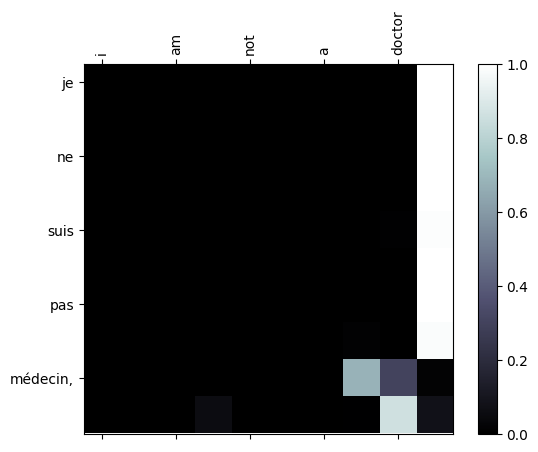

input = i am not a doctor but a teacher 
output = je ne suis pas médecin, de un enseignant.


In [114]:
evaluateAndShowAttention('i am not a doctor but a teacher ', encoder_att, decoder_att, training_dataset)

We played here with a dataset but did not rigorously evaluate. The usual metric for Machine Translation is the [**BLEU Score**](https://aclanthology.org/P02-1040.pdf). You can find existing implementations, for example in [Huggingface](https://huggingface.co/spaces/evaluate-metric/bleu). Rigorously experiment with
- A model with attention
- A model without attention

and use the BLEU score on the test set to compare them.

<div class='alert alert-block alert-info'>
            Code:</div>

In [115]:
import torch
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import numpy as np
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

def evaluate_model_for_bleu(encoder, decoder, dataset, dataloader, device):
    encoder.eval()
    decoder.eval()

    references = []
    hypotheses = []

    with torch.no_grad():
        for data in dataloader:
            input_tensor, target_tensor = data

            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            try:
                batch_size = input_tensor.size(0)
                max_length = input_tensor.size(1)

                encoder_outputs, encoder_hidden = encoder(input_tensor)

                decoder_input = torch.full((batch_size, 1), SOS_TOKEN, dtype=torch.long, device=device)
                decoder_hidden = encoder_hidden

                decoder_outputs, _, _ = decoder(encoder_outputs, decoder_hidden, max_length)

                for i in range(batch_size):
                    ref_words = []
                    for idx in target_tensor[i]:
                        idx_item = idx.item()
                        if idx_item == EOS_TOKEN:
                            break
                        if idx_item != PAD_TOKEN and idx_item in dataset.output_lang.idx2word:
                            ref_words.append(dataset.output_lang.idx2word[idx_item])

                    if len(ref_words) > 0:
                        references.append([ref_words])

                        hyp_words = []
                        for t in range(max_length):
                            topv, topi = decoder_outputs[i, t].topk(1)
                            word_idx = topi.cpu().item()

                            if word_idx == EOS_TOKEN:
                                break
                            if word_idx != PAD_TOKEN and word_idx in dataset.output_lang.idx2word:
                                hyp_words.append(dataset.output_lang.idx2word[word_idx])

                        hypotheses.append([w for w in hyp_words if w not in ['<UNK>', '<PAD>', '<EOS>']])

            except Exception as e:
                print(f"Error processing batch: {e}")
                continue

    if len(references) == 0 or len(hypotheses) == 0:
        return {'bleu1': 0, 'bleu2': 0, 'bleu3': 0, 'bleu4': 0}

    smoothie = SmoothingFunction().method1

    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    return {
        'bleu1': bleu1 * 100,
        'bleu2': bleu2 * 100,
        'bleu3': bleu3 * 100,
        'bleu4': bleu4 * 100
    }

def compare_models_with_bleu():
    print("==== Comparison about BLEU scores ====")

    print("\n1. No Attention...")
    try:
        no_attention_scores = evaluate_model_for_bleu(encoder, decoder, training_dataset, test_dataloader, device)
        print(f"No Attention BLEU-1: {no_attention_scores['bleu1']:.2f}")
    except Exception as e:
        print(f"Error in No attention: {e}")
        no_attention_scores = {'bleu1': 0, 'bleu2': 0, 'bleu3': 0, 'bleu4': 0}

    print("\n2. With Attention...")
    try:
        with_attention_scores = evaluate_model_for_bleu(encoder_att, decoder_att, training_dataset, test_dataloader, device)
        print(f"With Attention BLEU-1: {with_attention_scores['bleu1']:.2f}")
    except Exception as e:
        print(f"Error in With attention: {e}")
        with_attention_scores = {'bleu1': 0, 'bleu2': 0, 'bleu3': 0, 'bleu4': 0}

    print("\n==== Comparison about BLEU scores(%) ====")
    print(f"{'Model':<20} {'BLEU-1':<10} {'BLEU-2':<10} {'BLEU-3':<10} {'BLEU-4':<10}")
    print("-" * 60)
    print(f"{'No Attention':<20} {no_attention_scores['bleu1']:<10.2f} {no_attention_scores['bleu2']:<10.2f} {no_attention_scores['bleu3']:<10.2f} {no_attention_scores['bleu4']:<10.2f}")
    print(f"{'With Attention':<20} {with_attention_scores['bleu1']:<10.2f} {with_attention_scores['bleu2']:<10.2f} {with_attention_scores['bleu3']:<10.2f} {with_attention_scores['bleu4']:<10.2f}")

    improvements = {}
    for key in no_attention_scores:
        if no_attention_scores[key] > 0:
            improvements[key] = ((with_attention_scores[key] - no_attention_scores[key]) / no_attention_scores[key]) * 100
        else:
            improvements[key] = float('inf')

    print("\n==== Improvements by Attention ====")
    for key, value in improvements.items():
        print(f"{key}: {value:+.2f}%")

    return {
        'no_attention': no_attention_scores,
        'with_attention': with_attention_scores,
        'improvements': improvements
    }


try:
    results = compare_models_with_bleu()
except Exception as e:
    print(f"Error: {e}")
    print("Try again on cpu...")

    encoder.to('cpu')
    decoder.to('cpu')
    encoder_att.to('cpu')
    decoder_att.to('cpu')

    results = compare_models_with_bleu()

    encoder.to(device)
    decoder.to(device)
    encoder_att.to(device)
    decoder_att.to(device)


==== Comparison about BLEU scores ====

1. No Attention...
No Attention BLEU-1: 44.72

2. With Attention...
With Attention BLEU-1: 46.04

==== Comparison about BLEU scores(%) ====
Model                BLEU-1     BLEU-2     BLEU-3     BLEU-4    
------------------------------------------------------------
No Attention         44.72      36.32      28.97      22.96     
With Attention       46.04      35.68      27.81      22.16     

==== Improvements by Attention ====
bleu1: +2.94%
bleu2: -1.78%
bleu3: -4.00%
bleu4: -3.51%


We improved our initial model with attention. But considering our goal is to **generate text**, we should work on **decoding**. How would you go about implementing that given our current code ? Where is the ideal place to add a decoding function ?

<div class='alert alert-block alert-warning'>
            Question:</div>

Propose a modification of the *relevant function* in this lab in which to include **Beam search**, following the code you used in the previous lab. Similarly as before, compare the BLEU score of:
- A model decoding with Beam search
- A model using simple greedy decoding

<div class='alert alert-block alert-info'>
            Code:</div>

In [119]:
import torch
import torch.nn.functional as F
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def greedy_decode(encoder, decoder, sentence, input_lang, output_lang, max_length):
    encoder.eval()
    decoder.eval()

    input_tensor = tensorFromSentence(sentence, input_lang, max_length).unsqueeze(0).to(device)

    encoder_outputs, encoder_hidden = encoder(input_tensor)

    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)
    decoder_hidden = encoder_hidden
    decoded_words = []

    for _ in range(max_length):
        decoder_output, decoder_hidden = decoder.forward_step(decoder_input, decoder_hidden)

        topv, topi = decoder_output.squeeze(1).topk(1)
        word_idx = topi.item()

        if word_idx == EOS_TOKEN:
            break
        decoded_words.append(output_lang.idx2word[word_idx])

        decoder_input = topi.detach().view(1, 1)

    return decoded_words

def beam_search_decode(encoder, decoder, sentence, input_lang, output_lang, max_length, beam_width=3):
    encoder.eval()
    decoder.eval()

    input_tensor = tensorFromSentence(sentence, input_lang, max_length).unsqueeze(0).to(device)
    encoder_outputs, encoder_hidden = encoder(input_tensor)

    beams = [(torch.tensor([[SOS_TOKEN]], device=device), 0, encoder_hidden)]
    completed_sequences = []

    for _ in range(max_length):
        new_beams = []
        for seq, score, hidden in beams:
            decoder_input = seq[:, -1].view(1, 1)

            decoder_output, hidden = decoder.forward_step(decoder_input, hidden)

            topv, topi = decoder_output.squeeze(1).topk(beam_width)

            for i in range(beam_width):
                word_idx = topi[0][i].item()
                word_score = topv[0][i].item()

                new_seq = torch.cat([seq, torch.tensor([[word_idx]], device=device)], dim=1)
                new_score = score + word_score

                if word_idx == EOS_TOKEN:
                    completed_sequences.append((new_seq, new_score))
                else:
                    new_beams.append((new_seq, new_score, hidden))

        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

        if len(completed_sequences) >= beam_width:
            break

    if len(completed_sequences) > 0:
        best_sequence, _ = max(completed_sequences, key=lambda x: x[1])
    else:
        best_sequence = beams[0][0]

    decoded_words = [output_lang.idx2word[idx.item()] for idx in best_sequence.squeeze() if idx.item() not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]]

    return decoded_words

def evaluate_bleu_on_test(encoder, decoder, test_dataloader, dataset, method="greedy", beam_width=3):
    encoder.eval()
    decoder.eval()

    references = []
    hypotheses = []

    with torch.no_grad():
        for input_tensor, target_tensor in tqdm(test_dataloader):
            input_texts = [" ".join([dataset.input_lang.idx2word[idx.item()]
                                     for idx in input_tensor[i] if idx.item() not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]])
                           for i in range(len(input_tensor))]

            target_texts = [" ".join([dataset.output_lang.idx2word[idx.item()]
                                      for idx in target_tensor[i] if idx.item() not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]])
                            for i in range(len(target_tensor))]

            for i, input_sentence in enumerate(input_texts):
                if method == "greedy":
                    output_words = greedy_decode(encoder, decoder, input_sentence, dataset.input_lang, dataset.output_lang, dataset.max_length)
                elif method == "beam":
                    output_words = beam_search_decode(encoder, decoder, input_sentence, dataset.input_lang, dataset.output_lang, dataset.max_length, beam_width)

                references.append([target_texts[i].split()])
                hypotheses.append(output_words)

    smoothie = SmoothingFunction().method1
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
    return bleu_score * 100

bleu_greedy_test = evaluate_bleu_on_test(encoder, decoder, test_dataloader, training_dataset, method="greedy")
bleu_beam_test = evaluate_bleu_on_test(encoder, decoder, test_dataloader, training_dataset, method="beam", beam_width=3)

print(f"BLEU Score on Test Set (Greedy Decoding): {bleu_greedy_test:.2f}")
print(f"BLEU Score on Test Set (Beam Search Decoding): {bleu_beam_test:.2f}")

100%|██████████| 12/12 [00:05<00:00,  2.34it/s]

BLEU Score on Test Set (Greedy Decoding): 17.95
BLEU Score on Test Set (Beam Search Decoding): 15.44


Find a model on [Huggingface](https://huggingface.co/tasks/translation) for this task. Try to **understand what model it is** - and who trained it, on which data. Apply it to the same dataset and compute the BLEU score.

<div class='alert alert-block alert-info'>
            Code:</div>

In [120]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

def translate_with_huggingface(sentence):

    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
    translated = model.generate(**inputs, max_length=50)
    output = tokenizer.decode(translated[0], skip_special_tokens=True)
    return output

def evaluate_huggingface_bleu(test_dataloader, dataset):

    references = []
    hypotheses = []

    print("Translating test set and computing BLEU score...")

    for input_tensor, target_tensor in tqdm(test_dataloader):

        input_texts = [dataset.input_lang.idx2word[idx.item()] for idx in input_tensor[0] if idx.item() not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]]
        target_texts = [dataset.output_lang.idx2word[idx.item()] for idx in target_tensor[0] if idx.item() not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]]

        input_sentence = " ".join(input_texts)
        target_sentence = " ".join(target_texts)

        output_sentence = translate_with_huggingface(input_sentence)

        references.append([target_sentence.split()])
        hypotheses.append(output_sentence.split())

    smoothie = SmoothingFunction().method1
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
    return bleu_score * 100


bleu_huggingface = evaluate_huggingface_bleu(test_dataloader, training_dataset)
print(f"BLEU Score on Test Set (Hugging Face Model - {model_name}): {bleu_huggingface:.2f}")

Translating test set and computing BLEU score...


100%|██████████| 12/12 [00:01<00:00, 10.43it/s]

BLEU Score on Test Set (Hugging Face Model - Helsinki-NLP/opus-mt-en-fr): 37.70
